# Surveillance du COVID_19 pendant le deconfinement en France

## Origine des données
- nb hospitalisation, retour à domicile et décès quotidien sur le COVID19 sur le site data.gouv.fr
- nb habitant par département

In [1]:
from matplotlib import pyplot
import matplotlib
import math
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
from scipy import stats
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import datetime
# Importation des librairies pour l'analyse des composantes principales
from sklearn import datasets
from sklearn import decomposition
import statsmodels.api as sm
## Importation des données sous forme de dataframe ##
DonneesHosp = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',sep = ';')
DonneesDep = pd.read_csv('Donnees\Population_departement.csv',sep = ';')
DonneesHosp = DonneesHosp.dropna(how = 'any') # suppression des lignes avec NaN
DonneesTestsViro = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675',sep = ',')
DonneesTestsViro = DonneesTestsViro.dropna(how = 'any') # suppression des lignes avec NaN

## Traitement des données

In [2]:
# filtrage des lignes uniquement avec la somme homme et femme
# Lien avec les données département
Donneesmixte = DonneesHosp[DonneesHosp['sexe']==0]
DonneesTestsViro = DonneesTestsViro.loc[DonneesTestsViro['cl_age90'] == 0] # conserve somme des classes d'age
# suppression colonne sexe et reanimation 
del Donneesmixte['sexe']
del Donneesmixte['rea']
# tri les valeurs par departement et jour
Dj = Donneesmixte.sort_values(by = ['dep', 'jour']) 
# Remise en forme du numero de département sur 2 chiffres minimum (0x)
for i in range(len(DonneesDep)-1): # Parcours des lignes dans l'ordre département + jour
    if len(DonneesDep.loc[DonneesDep.index[i], 'CODDEP']) == 1:
        DonneesDep.loc[DonneesDep.index[i], 'CODDEP'] = '0' + DonneesDep.loc[DonneesDep.index[i], 'CODDEP']
# Jointure sur le département pour récupérer le nombre d'habitant (PTOT) et les tests virologiques
Dj = pd.merge(Dj, DonneesDep, left_on = ['dep'], right_on = ['CODDEP'])
Dj = pd.merge(Dj, DonneesTestsViro, left_on = ['dep','jour'], right_on = ['dep','jour'], how = 'left' )
# Suppression de colonne
del Dj['CODDEP']
del Dj['NBARR']
del Dj['NBCAN']
del Dj['PMUN']
del Dj['cl_age90']

In [3]:
# Calcul pour la France entière = somme des départements
for j in Dj[Dj['dep']== '01'].itertuples(): # itération sur tous les jours
    ligne = len(Dj) # ajoute une ligne à la fin
    Dj.loc[ligne,['dep']] = '999'
    Dj.loc[ligne,['jour']] = j.jour
    Dj.loc[ligne,['DEP']] = 'France'
    Dj.loc[ligne,['hosp']] =  Dj[Dj['jour'] == j.jour]['hosp'].sum()  
    Dj.loc[ligne,['rad']] =  Dj[Dj['jour'] == j.jour]['rad'].sum()
    Dj.loc[ligne,['dc']] =  Dj[Dj['jour'] == j.jour]['dc'].sum()
    Dj.loc[ligne,['NBCOM']] =  Dj[Dj['jour'] == j.jour]['NBCOM'].sum()
    Dj.loc[ligne,['PTOT']] =  Dj[Dj['jour'] == j.jour]['PTOT'].sum()
    if Dj[Dj['jour'] == j.jour]['p'].isna().sum() < 10:
        Dj.loc[ligne,['p']] =  Dj[Dj['jour'] == j.jour]['p'].sum()
        Dj.loc[ligne,['t']] =  Dj[Dj['jour'] == j.jour]['t'].sum()
    else:
        Dj.at[ligne,'p'] = float('nan')
        Dj.at[ligne,'p'] = float('nan')
Dj = Dj.reset_index(drop = True) # réindexe

### Calcul des indicateurs par département
- entrées en hospitalisation
- sorties en hospitalisation : guérison et décès
- taux d'hospitalisation : rapport du nombre d'hospitalisation pour 100 000 habitant (Thosp)
- taux de reproduction : rapport du nombre d'entrées pour 100 hospitalisations (Treprod)
- taux de reproduction lissé : filtre du 1er ordre avec une constante de temps de 3 jours (Treprodmoy)

In [4]:
# Initialisation de colonne de colonnnes
Dj['Entree'] = 0 # Colonne des entrées en hospitalisation
Dj['Sortie'] = 0 # Colonne des sorties en hospitalisation
Dj['Thosp'] = 0 # proportion : nb d'hospitalisation par 100 000 habitatns
Dj['Treprod'] = 0 # taux de reproduction quotidien : nb entrée  pour 100 hospitalisation
Dj['Treprodmoy'] = 0 # taux de reproduction lissé +/- 3 jours : nb entrée  pour 100 hospitalisation
Dj['tendance'] = 0 # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['incoherence'] = False # 
## Calcul des entrées, tests lissées et R0 à +/- 3 jours et ramenés à 100 000 habitants
Dj['Rj'] = float('nan') # taux de reproduction actualisé
Dj['Emoy'] = float('nan') # lissage proportion entrée +/- 3 jours
Dj['VEmoy'] = 0 # 2 si calculé avec toutes les données / 1 si calculé partiellement / 0 sinon
Dj['pmoy'] = float('nan') # lissage proportion de test +/- 3 jours
Dj['Vpmoy'] = 0 # 2 si calculé avec toutes les données / 1 si calculé partiellement / 0 sinon


# Calcul entree, sortie, rapport entree/hospitalisation et tendance
dep = 'Ain'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    # print('\r','departement : ',i, end='')
    Dj.at[i, 'Thosp'] = round(Dj.at[i, 'hosp'] / Dj.at[i, 'PTOT'] * 100000 )
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            print('\r','calcul entree : ' + dep + '                              ', end='')
        # Calcul des entrées, sorties et taux de reproduction
        if i > 0 and Dj.at[i, 'dep'] == Dj.at[i-1, 'dep']: # le point précédent est dans le même département 
            if (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']) &  (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']  + Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            elif (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']
            elif (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                 Sortie =  Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            else: Sortie = 0
            if Sortie > Dj.at[i-1, 'hosp']: # les sorties ne doivent pas dépasser les hospitalisations
                Sortie = 0
                Dj.at[i, 'incoherence'] = True
            Entree = Sortie + Dj.at[i, 'hosp'] - Dj.at[i-1, 'hosp']
            
            datedebut = datetime.date(int(str.split(Dj.at[i-1,'jour'],'-')[0]),
                                  int(str.split(Dj.at[i-1,'jour'],'-')[1]),int(str.split(Dj.at[i-1,'jour'],'-')[2]))
        
            datefin = datetime.date(int(str.split(Dj.at[i,'jour'],'-')[0]),
                                  int(str.split(Dj.at[i,'jour'],'-')[1]),int(str.split(Dj.at[i,'jour'],'-')[2]))
            Njour = (datefin - datedebut).days
            if Entree > 0 and Entree < 0.6 * Njour * Dj.at[i, 'hosp'] and  Dj.at[i, 'hosp'] > 1:
                # en dessous de 15 hosp, le taux de reproduction a peu de sens et les entrées > 60 % du nb hosp
                Dj.at[i, 'Treprod'] = round(Entree / Njour / Dj.at[i, 'hosp'] * 100)
                Dj.at[i, 'Entree'] = Entree

            Dj.at[i, 'Sortie'] = Sortie
        
            
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    # print('\r','departement : ',i, end='')
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            print('\r','lissage entree : ' + dep + '                              ', end='')
        Emoy3 = 0    
        if i>=3 and i < len(Dj)-3 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+3,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+3,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 2
        elif i>=3 and i < len(Dj)-2 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+2,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+2,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1
        elif i>=3 and i < len(Dj)-1 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+1,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+1,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1
        elif i>=3 and i < len(Dj) and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1

        if i>=3 and i < len(Dj)-3 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-2 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+2,'DEP'] == dep and math.isnan(Dj.at[i+2,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+2,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 1
        elif i>=3 and i < len(Dj)-1 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+1,'DEP'] == dep and math.isnan(Dj.at[i+1,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+1,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2) 
            Dj.at[i,'Vpmoy'] = 1
        elif i>=3 and i < len(Dj) and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i,'DEP'] == dep and math.isnan(Dj.at[i,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 1
        # pas de valeur au début
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i-2,'DEP'] == dep and math.isnan(Dj.at[i-2,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-2:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i-1,'DEP'] == dep and math.isnan(Dj.at[i-1,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-1:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i,'DEP'] == dep and math.isnan(Dj.at[i,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
    
        if i>=14  and  Dj.at[i-14,'DEP'] == dep :
            Emoy14 = Dj.loc[i-14:i,'Emoy'].mean()
            if Emoy14 > 0:
                Dj.at[i,'Rj'] = round(Dj.at[i,'Emoy'] / Emoy14 ,2)  
            
        if Emoy3 > 0 and Dj.at[i, 'hosp'] > 15:  
            Dj.at[i, 'Treprodmoy'] = round(Emoy3 / Dj.at[i, 'hosp'] * 100) 
            

            #if Njour == 1:alpha = 0.7
            #elif Njour == 2 : alpha = 0.7 * 0.7
            #elif Njour == 3 : alpha = 0.7 * 0.7 * 0.7
            #else : alpha = 0.7
            #Dj.at[i, 'Treprodmoy'] = alpha * Dj.at[i-1, 'Treprodmoy'] + (1 - alpha) * Dj.at[i, 'Treprod']


 lissage entree : France                                               

### Classification des départements
- selon le taux d'hospitalisation en fin de période (CThosp)
- selon le taux de reproduction à chaque date (CTreprod)

In [5]:
Dj['CThosp'] = -1 # classement du taux d'hospitalisation (en cluster)
Dj['CTreprod'] = 0 # Classement du taux de reproduction (en cluster)
## Regroupement des départements en taux d'hospitalisation final ##

# x = taux d'hospitalisation sur la date la plus récente
#x = Dj[Dj['jour']== Dj['jour'].max()]['Thosp']
x = Dj[:]['Thosp']
# Création du model K-means
model=KMeans(n_clusters=5)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((5, 1), dtype = int)

for i in range(len(model.cluster_centers_)):
    if (model.cluster_centers_[i] == np.sort(model.cluster_centers_,0)[4] ) :
        intensite[i] ='4' # proportion la plus elevée
    elif (model.cluster_centers_[i] == np.sort(model.cluster_centers_,0)[3] ) :
        intensite[i] ='3' # proportion la plus elevée
    elif (model.cluster_centers_[i] == np.sort(model.cluster_centers_,0)[2] ) :
        intensite[i] ='2' # proportion la plus 
    elif (model.cluster_centers_[i] == np.sort(model.cluster_centers_,0)[1] ) :
        intensite[i] ='1' # proportion la plus elevée
    else:
        intensite[i] ='0' # proportion intermédiaire

# integration des résultats dans le tableau dep+jour
#Dj.loc[Dj['jour'] == Dj['jour'].max(),'CThosp'] = intensite[model.labels_]
Dj.loc[:,'CThosp'] = intensite[model.labels_]


#print('Classement Thosp : ', np.sort(model.cluster_centers_,0))

## Regroupement des départements par taux de reproduction sur la période ##
x = Dj.loc[:]['Treprodmoy'] # x = taux de reproduction lissé sur toute la période
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
centreTreprod  = np.zeros((3, 1), dtype = float)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
        centreTreprod [2] = model.cluster_centers_[i]
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
        centreTreprod [0] = model.cluster_centers_[i]
    else:
        intensite[i] ='1' # proportion intermédiaire
        centreTreprod [1] = model.cluster_centers_[i]
# integration des résultats dans le tableau dep+jour
Dj.loc[:,'CTreprod'] = intensite[model.labels_]



### Création d'une alerte
- en cas d'un taux de reproduction  élevé 
- dans la dernière semaine

In [6]:
Dj['alerte'] = False # indique un taux de reproduction important 
## Creation d'une alerte si sur les 4 derniers jours le taux de reproduction lissé n'est pas faible
'''
for dep in Dj[(Dj['jour']== Dj['jour'].max())] ['DEP'].values: # parcours des départements
    if Dj.loc[(Dj['DEP'] == dep)]['CTreprod'].iloc[-3:-2].max() > 0: # condition sur 3 jours
        Dj.loc[(Dj['jour']== Dj['jour'].max()) & (Dj['DEP'] == dep),'alerte'] = True
    else:Dj.loc[(Dj['jour']== Dj['jour'].max()) & (Dj['DEP'] == dep),'alerte'] = False
'''  
dep = 'Ain'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            #print('\r','calcul alarme : ' + dep + '                              ', end='')
        if Dj.at[i,'CThosp'] == 0 and Dj.at[i,'CTreprod'] < 2 :Dj.at[i,'alerte'] = False
        elif Dj.at[i,'CThosp'] == 0 and Dj.at[i,'CTreprod'] == 2:Dj.at[i,'alerte'] = True
        elif Dj.at[i,'CThosp'] > 0 and Dj.at[i,'CTreprod'] == 0:Dj.at[i,'alerte'] = False
        elif Dj.at[i,'CThosp'] > 0 and Dj.at[i,'CTreprod'] > 0 :Dj.at[i,'alerte'] = True

In [7]:
## Construction des courbes

In [8]:
###  Evolution des taux d'hospitalisation

In [9]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_Thosp(dep):
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )) : # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            epaisseur = 1
            legende =''
            transparence = 0.5
            if Dj.at[i,'CThosp'] >= 3 :
                if  Dj.at[i,'alerte'] == False :col = 'darkgoldenrod';epaisseur = 3;transparence =1
                else:col = 'red';epaisseur = 3;transparence =1 # en d'alerte avec des hospitalisations élevées
            elif Dj.at[i,'CThosp'] >= 1 :
                if  Dj.at[i,'alerte'] == False :col = 'darkorange';epaisseur = 1;transparence =1
                else:col = 'deeppink';epaisseur = 3;transparence =1 # en d'alerte avec des hospitalisations élevées
            elif Dj.at[i,'alerte'] == True :col = 'deeppink';epaisseur = 3;transparence =1
            else:col ='grey';transparence =0.7
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black';transparence =1
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'blue';legende =Dj.at[i,'DEP'];transparence =1
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],col,linewidth = epaisseur,label = legende, alpha = transparence)
    # Paramètres généraux
    if dep == 'France':
        pyplot.plot(0,0,'red', linewidth = 5, label = 'Hospitalisation et reproduction élevées')
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = 'Reproduction élevée')
        pyplot.plot(0,0,'darkgoldenrod',linewidth = 5, label = 'Hospitalisation élevée')
        pyplot.plot(0,0,'darkorange',linewidth = 5,label = 'Hospitalisation moyenne')
        pyplot.plot(0,0,'grey',linewidth = 1,label = 'Hospitalisation faible')
    pyplot.plot(0,0,'black',linewidth = 5, label = 'France')
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution du taux hospitalisation par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
    if dep == 'France':fig1.savefig('Images\Evolution des hospitalisations_' + dep + '.png')
#courbe_Thosp('France')

In [10]:
### Evolution des taux de reproduction

In [11]:
## Visualisation du taux d'hospitalisation de l'ensemble des départements pour vérifer la cohérence ##
def courbe_TEntree(dep):
#dep = '63'
    fig2 = pyplot.figure(2,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )): 
            # recherche de la dernière ligne du département
            couleur = 'grey'
            epaisseur = 1
            legende =''
            transparence = 0.7
            if  Dj.at[i,'dep'] == '999' : couleur = 'black' ; epaisseur = 5 ; legende='France';transparence = 1
            elif  Dj.at[i,'DEP'] == dep : couleur = 'blue' ; epaisseur = 5 ; legende=Dj.at[i,'DEP'];transparence = 1
            elif Dj.at[i,'alerte'] == True :couleur = 'deeppink';epaisseur = 2;transparence = 1
            # Courbe du département
            if Dj.at[i, 'incoherence'] == False:
                Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Treprodmoy']] # récupération du département
                pyplot.plot(Djdep['jour'],Djdep['Treprodmoy'],
                            couleur,linewidth=epaisseur,label =legende, alpha = transparence)
    # Paramètres généraux
    pyplot.axhline(y = centreTreprod [2],color ='red',linewidth = 3)
    if centreTreprod [1] != 0 :
        pyplot.axhline(y = centreTreprod [1],color ='deeppink',linewidth = 3)
    pyplot.axhline(y = centreTreprod [0],color ='grey',linewidth = 3)
    pyplot.title("Evolution du taux de reproduction par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Entree / hospitalisation (%)' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    if dep == 'France':
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = 'Reproduction élevée')
        pyplot.plot(0,0,'grey',linewidth = 1,label = 'Reproduction faible')
    pyplot.legend(loc='upper right')
    pyplot.show() 
    if dep == 'France':fig2.savefig('Images\Evolution des entrées_' + dep + '.png')
#courbe_TEntree('France')

In [12]:
### Evolution pour les taux d'hospitalisation les plus élevés

In [13]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_Thosphaut():
    icol = 0
    cm = matplotlib.cm.get_cmap('tab20')
    fig3 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and ( 
            (Dj.at[i,'DEP'] == 'France') |
            (Dj.at[i,'CThosp'] == 4) | 
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 3) and 
             (Dj.at[i,'CThosp'] == 3)) |
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 2) and 
             (Dj.at[i,'CThosp'] == 2)) |
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 1) and 
             (Dj.at[i,'CThosp'] == 1)) ):
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            legende =  Dj.at[i,'DEP']
            #col = lcol[icol]
            if icol >= 20:icol = 0
            col = cm.colors[icol]
            icol = icol + 1 
            epaisseur = 5
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black'
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],c=col,linewidth = epaisseur,label = legende)
    # Paramètres généraux
    pyplot.legend(loc='upper left')
    if Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 4:
        pyplot.title("Evolution des départements avec un taux d'hospitalisation très élevé")
    elif Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 3:
        pyplot.title("Evolution des départements avec un taux d'hospitalisation élevé")
    elif Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 2:
        pyplot.title("Evolution des départements avec un taux d'hospitalisation moyen")
    elif Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 1:
        pyplot.title("Evolution des départements avec un taux d'hospitalisation bas")
    else: pyplot.title("Evolution du taux d'hospitalisation très bas de la France")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
    
#courbe_Thosphaut() # pour test

In [14]:
### Evolution d'une liste de département

In [15]:
## Affichage  pour un département
def courbe_departement(ldep):
    fig4 = pyplot.figure(3,figsize = (15, max(5,2.0*len(ldep))))
    for idep in range(len(ldep)):
        dep = ldep[idep]
        pyplot.subplot(int(round(len(ldep)/2+0.1)),min(2,len(ldep)),idep+1)
        if dep == 'France': couleur = 'black'
        else: couleur = 'blue' ;
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Thosp'],couleur,linewidth = 5,label='Hospitalisation pour 100 000 habitants')
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprod'],'grey',linewidth = 1,label="Entrée pour 100 hospitalisations")
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprodmoy'],'grey',linewidth = 5,label="Entrée lissée sur 7 jours")
        if dep != 'France':
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Thosp'],'black',linewidth = 5 ,label='Hospitalisation France')
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Treprodmoy'],'black',linewidth = 3, label='Entrée France')
        
        if len(ldep) == 1:
            pyplot.legend(loc='upper left')
            pyplot.grid()
            axes = pyplot.gca()
            axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
        else:
            axes = pyplot.gca()
            axes.yaxis.grid()
            axes.xaxis.grid()
            axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8)) # impose 8 graduations maxi
            axes.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(6)) # impose 8 graduations maxi
            axes.xaxis.set_tick_params(labelsize = 8)
          #  axes.xaxis.set_ticklabels([],fontsize = 8)              
        pyplot.title(Dj[Dj['DEP'] == dep]['DEP'].max(),color ='blue',fontweight = 'bold' )
        if len(ldep) == 1:
            pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
            pyplot.ylabel('taux' , fontsize = 12) # titre des ordonnées
            # mise en forme du label des x (rotation verticale)
            for label in pyplot.gca().xaxis.get_ticklabels():
                label.set_rotation(90)
        if centreTreprod [1] != 0 :
            pyplot.axhline(y = (centreTreprod [1] + centreTreprod [0])/2,color ='deeppink',linewidth = 1)
        else:
            pyplot.axhline(y = (centreTreprod [2] + centreTreprod [0])/2,color ='deeppink',linewidth = 1)
    pyplot.show()  
# courbe_departement('France')
# Sert à faire une interface qui selectionne un département
# rq : la sauvegarde en Markdown ne se fait pas correctement
#courbe_departement(['Allier','Aude','Isère','Ain'])

## Surveillance de la tendance par département au  15 juin 2020
### Evolution des taux d'hospitalisation

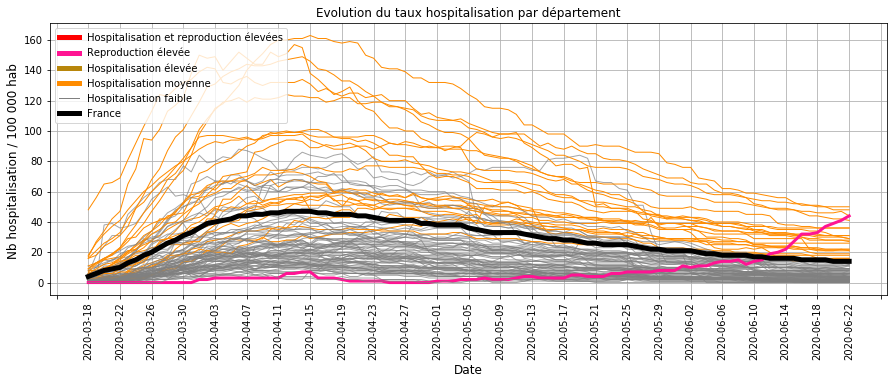

In [16]:
courbe_Thosp('France')

#### Commentaires :
- la majorité des départements (GRIS) sont proches ou en dessous de la moyenne nationale (NOIR),
- les autres départements dont le taux d'hospitaliation est moyen (ORANGE) ont une tendance à la baisse,
- le département de la Guyane dont le taux de reproduction est elevé (ROSE) a un taux d'hospitalisation qui devient élevé.

### Evolution des taux de reproduction

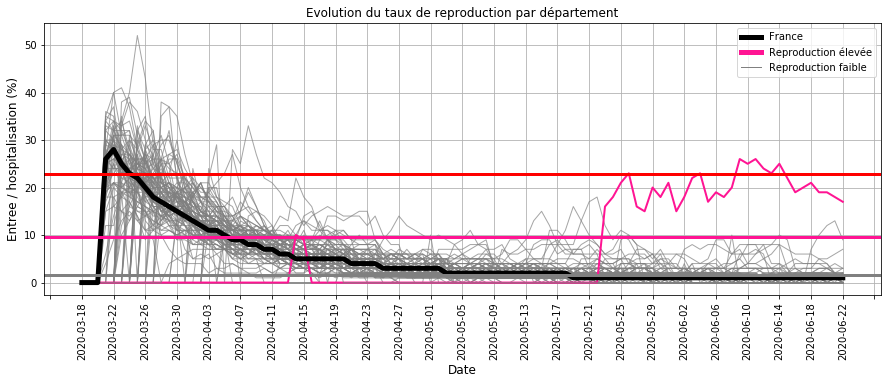

In [17]:
courbe_TEntree('France')

#### Commentaires :
- de mi-avril à mi-mai, le taux de reproduction est faible du à l'impact du confinement
- à partir du déconfinement, quelques départements ont ponctulellement un taux de reproduction au-dessus des autres départements (Limite ROSE)
- à l'exception de la Guyane (Courbe ROSE) où la tendance persiste depuis 1 mois.

### Evolution des taux d'hospitalisation les plus élevés

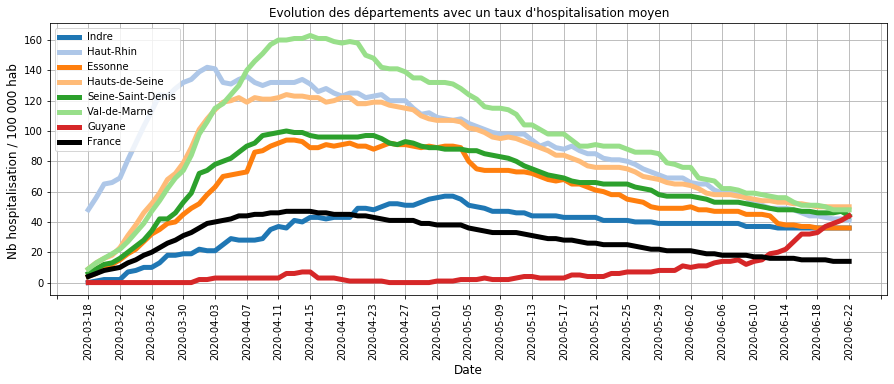

In [18]:
courbe_Thosphaut()

#### Commentaires : 
Les départements dont les taux d'hospitalisation sont les plus élevés sont à la baisse depuis plusieurs semaines et les valeurs très éloignées de celles atteintes au plus fort de l'épidémie (début Avril).

Seule la Guyane a un taux d'hospitalisation qui augmente fortement.

### Evolution des taux de reproduction élevés
- le taux d'hospitalisation est représenté en BLEU pour le département et en NOIR EPAIS pour la France entière,
- la vitesse de reproduction est représentée en GRIS EPAIS pour le département et en NOIR FIN pour la France entière,
- le seuil en ROSE correpond à limite où le taux de reproduction du département est au dessus de la majorité des autres départements.

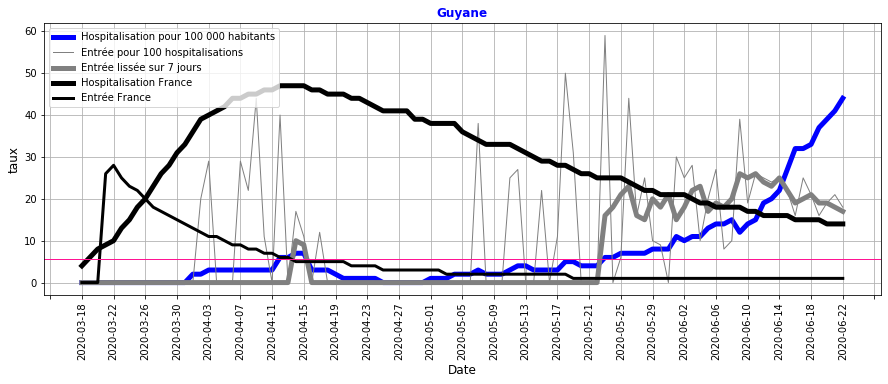

In [19]:
courbe_departement(Dj[(Dj['jour']== Dj['jour'].max()) & (Dj['alerte'] == True)]['DEP'].values)

#### Commentaires :
Seule la Guyane a un taux de reproduction (GRIS FONCE) elevé sur les derniers jours.

Cette augmentation depuis 1 mois se traduit par une très forte augmentation du taux d'hospitalisation (BLEU) qui atteint la valeur du pic épidémique en métropole de mi Avril.



## Bilan sur la circulation du virus au 22 juin 2020 :
La majorité des départements ont une chute du nombre d'hospitalisation, ce qui traduit une faible circulation du virus.

Ponctuellement, certains départements ont un taux de reproduction qui augmente. Le maintien d'un système de surveillance est donc nécessaire pour s'assurer que ce dernier ne persiste pas.

Seule la Guyane avec une hausse constante des hospitalisations depuis 1 mois subit une accélération de la circulation du virus. Les mesures insuffisantes nécessitent d'être renforcées.


## Sauvegarde

In [24]:
## Sauvegarde des fichiers
# Sous Markdow : cela génère un sous repertoire avec les images
#!jupyter nbconvert --to markdown --no-input  Surveillance_deconfinement_2020_06_22.ipynb
# Sous HTML
#!jupyter nbconvert --to html --no-input  Surveillance_deconfinement_2020_06_22.ipynb